## **DATA PREPROCESSING ON HOME LOAN DATA**

1. **Handle Skewed Variables** - Log transform `ApplicantIncome`, `CoapplicantIncome`, `LoanAmount`, `Loan_Amount_Term`
2. **Outlier Treatment** - IQR-capping for extremes
3. **Feature Engineering** - Create Total_Income (sum of ApplicantIncome and CoapplicantIncome) and Loan_to_Income Ratio for risk assessment.
4. **Feature Selection** - Keep high-signal features, evaluate low-signal ones
5. **Scaling** - StandardScaler/MinMaxScaler for continuous variables - preventing loan amount and income from dominating the model.
6. **Target Handling** - Classification approach with stratified splits since our target is categorical.

**Key EDA to Implement**
- **High-signal features**: No high signal features as there are no strong correlation with target
- **Low-signal features**: CoapplicantIncome and LoanAmount are to be evaluated for removal.
- **Feature Engineering** - Create Total_Income (sum of ApplicantIncome and CoapplicantIncome) and Loan_to_Income Ratio for risk assessment.

### **1. Import Libraries and Load Data**

In [45]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Preprocessing libraries
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix

# Statistical libraries
from scipy import stats
from scipy.stats import zscore, skew

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


In [46]:
# Load in the dataset

df = pd.read_csv("home_loan_eda.csv")
df.head()
# df.tail()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,1,0,0,0,0,5849,0.0,128.0,360.0,1,2,1
1,LP001003,1,1,1,0,0,4583,1508.0,128.0,360.0,1,0,0
2,LP001005,1,1,0,0,1,3000,0.0,66.0,360.0,1,2,1
3,LP001006,1,1,0,1,0,2583,2358.0,120.0,360.0,1,2,1
4,LP001008,1,0,0,0,0,6000,0.0,141.0,360.0,1,2,1


In [47]:
good_cred = df[df['Credit_History'] == 1]

good_cred.Loan_Status.value_counts()


Loan_Status
1    378
0     97
Name: count, dtype: int64

### **2. EDA-Based Data Quality Assessment**

In [48]:
# Create a copy for preprocessing
df_processed = df.copy()

df_processed.set_index('Loan_ID')
# 1. Check for missing values 
print("\n1. Missing Values:")
missing_values = df_processed.isnull().sum()
if missing_values.sum() > 0:
  print(missing_values[missing_values > 0])
else:
  print("No missing values found (as expected from EDA)")

# 2. Check for duplicates
print("\n2. Duplicate Rows:")
duplicates = df_processed.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")
if duplicates > 0:
  print(f"Percentage of duplicates: {(duplicates/len(df_processed))*100:.2f}%")


1. Missing Values:
No missing values found (as expected from EDA)

2. Duplicate Rows:
Number of duplicate rows: 0


In [49]:
# 3. Check skewness for variables identified in EDA as right-skewed
print("\n3. Skewness Analysis (EDA identified right-skewed variables)")
skewed_vars = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Total_Income']
for var in skewed_vars:
  if var in df_processed.columns:
    skewness = skew(df_processed[var])
    print(f"{var}: skewness = {skewness:.3f} ({'right-skewed' if skewness > 0.5 else 'approximately normal'})")


3. Skewness Analysis (EDA identified right-skewed variables)
ApplicantIncome: skewness = 6.524 (right-skewed)
CoapplicantIncome: skewness = 7.473 (right-skewed)
LoanAmount: skewness = 2.736 (right-skewed)


In [50]:
df_processed = df_processed.drop('Loan_ID', axis=1)
df_processed.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,1,0,0,0,0,5849,0.0,128.0,360.0,1,2,1
1,1,1,1,0,0,4583,1508.0,128.0,360.0,1,0,0
2,1,1,0,0,1,3000,0.0,66.0,360.0,1,2,1
3,1,1,0,1,0,2583,2358.0,120.0,360.0,1,2,1
4,1,0,0,0,0,6000,0.0,141.0,360.0,1,2,1


In [51]:
# 4. Check correlation with target (EDA evidence)
print("\n4. Correlation with Loan Status (EDA Evidence):")
correlations = df_processed.corr()['Loan_Status'].sort_values(key=abs, ascending=False)
print("High-signal features (|correlation| > 0.2):")
high_signal = correlations[abs(correlations) > 0.2].drop('Loan_Status')
for feature, corr in high_signal.items():
  print(f"  {feature}: {corr:.3f}")

print("\nLow-signal features (|correlation| < 0.1):")
low_signal = correlations[abs(correlations) < 0.1]
for feature, corr in low_signal.items():
  print(f"  {feature}: {corr:.3f}")


4. Correlation with Loan Status (EDA Evidence):
High-signal features (|correlation| > 0.2):
  Credit_History: 0.423

Low-signal features (|correlation| < 0.1):
  Married: 0.097
  Education: -0.086
  CoapplicantIncome: -0.059
  LoanAmount: -0.033
  Property_Area: 0.032
  Loan_Amount_Term: -0.023
  Gender: 0.018
  Dependents: 0.010
  ApplicantIncome: -0.005
  Self_Employed: -0.004


### **3. Handle Duplicates**

In [52]:
# Remove duplicates if any (EDA didn't report duplicates, but let us be thorough)
if duplicates > 0:
  print(f"Removing {duplicates} duplicate rows...")
  df_processed = df_processed.drop_duplicates()
  print(f"Dataset shape after removing duplicates: {df_processed.shape}")
else:
  print("✓ No duplicates to remove (as expected from EDA)")

✓ No duplicates to remove (as expected from EDA)


### **4. Log-Transform Skewed Variables (EDA Recommendation)**

Based on EDA findings, transform the right-skewed variables identified

In [53]:
# Log-transform skewed variables as recommended by EDA
print("=== LOG-TRANSFORMING SKEWED VARIABLES ===")
print("EDA identified these variables as right-skewed and recommended log transformation")

for var in skewed_vars:
  if var in df_processed.columns:
    # Check if variable has zero or negative values
    min_val = df_processed[var].min()
    if min_val <= 0:
      # Use log1p for variables with zeros
      df_processed[f'{var}_log'] = np.log1p(df_processed[var])
      print(f"✓ {var}: Applied log1p transformation (had {min_val:.3f} minimum value)")
    else:
      # Use log for positive values only
      df_processed[f'{var}_log'] = np.log(df_processed[var])
      print(f"✓ {var}: Applied log transformation")

    # Check skewness before and after
    original_skew = skew(df_processed[var])
    transformed_skew = skew(df_processed[f'{var}_log'])
    print(f"  Original skewness: {original_skew:.3f} → Transformed skewness: {transformed_skew:.3f}")

print(f"\nDataset shape after log transformation: {df_processed.shape}")
print("New log-transformed columns:", [col for col in df_processed.columns if '_log' in col])

=== LOG-TRANSFORMING SKEWED VARIABLES ===
EDA identified these variables as right-skewed and recommended log transformation
✓ ApplicantIncome: Applied log transformation
  Original skewness: 6.524 → Transformed skewness: 0.478
✓ CoapplicantIncome: Applied log1p transformation (had 0.000 minimum value)
  Original skewness: 7.473 → Transformed skewness: -0.173
✓ LoanAmount: Applied log transformation
  Original skewness: 2.736 → Transformed skewness: -0.195

Dataset shape after log transformation: (614, 15)
New log-transformed columns: ['ApplicantIncome_log', 'CoapplicantIncome_log', 'LoanAmount_log']


In [54]:
df_processed.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,ApplicantIncome_log,CoapplicantIncome_log,LoanAmount_log
0,1,0,0,0,0,5849,0.0,128.0,360.0,1,2,1,8.674026,0.000000,4.852030
1,1,1,1,0,0,4583,1508.0,128.0,360.0,1,0,0,8.430109,7.319202,4.852030
2,1,1,0,0,1,3000,0.0,66.0,360.0,1,2,1,8.006368,0.000000,4.189655
3,1,1,0,1,0,2583,2358.0,120.0,360.0,1,2,1,7.856707,7.765993,4.787492
4,1,0,0,0,0,6000,0.0,141.0,360.0,1,2,1,8.699515,0.000000,4.948760


### **5. Outlier Treatment (EDA Recommendation)**

Based on EDA findings, we would handle outliers using **Robust method** because we do not want to remove them but handle them naturally since the outliers are still valid.

In [55]:
# Select numerical columns
num_features = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']

In [56]:
# Check for outliers using IQR
def get_outliers(dataset):
  Q1 = dataset.quantile(0.25)

  Q3 = dataset.quantile(0.75)

  IQR = Q3 - Q1

  lower_bound = Q1 - (1.5 * IQR)
  higher_bound = Q3 + (1.5 * IQR)

  outliers = df_processed[(dataset < lower_bound) | (dataset > higher_bound)]

  return outliers

for col in num_features:
  get_outliers(df_processed[col])
  print(f"{col}: {len(get_outliers(df_processed[col]))}")

ApplicantIncome: 50
CoapplicantIncome: 18
LoanAmount: 41
Loan_Amount_Term: 88


### **6. Feature Engineering**

Implement the specific feature engineering recommendations from the EDA report

In [57]:
# Add a new column for Total Income which is a combination of ApplicantIncome and CoapplicantIncome
df_processed['Total_Income'] = df_processed['ApplicantIncome'] + df_processed['CoapplicantIncome']
print("- Total_Income: ApplicantIncome + CoapplicantIncome")

# Create a loan to income ratio
df_processed['Loan_Income_Ratio'] = df_processed['LoanAmount'] / df_processed['Total_Income']
print("- Loan_Income_Ratio: LoanAmount / Total_Income")

# Create a loan to term ratio
df_processed['Loan_Term_Ratio'] = df_processed['LoanAmount'] / df_processed['Loan_Amount_Term']
print("- Loan_Term_Ratio: LoanAmount / Loan_Amount_Term")

# Create an income to term ratio
df_processed['Income_Term_Ratio'] = df_processed['Total_Income'] / df_processed['Loan_Amount_Term']
print("- Income_Term_Ratio: Total_Income / Loan_Amount_Term")

print(f"\nDataset shape after feature engineering: {df_processed.shape}")
print(f"New engineered features: {[col for col in df_processed.columns if col not in df.columns]}")

df_processed.head()

- Total_Income: ApplicantIncome + CoapplicantIncome
- Loan_Income_Ratio: LoanAmount / Total_Income
- Loan_Term_Ratio: LoanAmount / Loan_Amount_Term
- Income_Term_Ratio: Total_Income / Loan_Amount_Term

Dataset shape after feature engineering: (614, 19)
New engineered features: ['ApplicantIncome_log', 'CoapplicantIncome_log', 'LoanAmount_log', 'Total_Income', 'Loan_Income_Ratio', 'Loan_Term_Ratio', 'Income_Term_Ratio']


,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,ApplicantIncome_log,CoapplicantIncome_log,LoanAmount_log,Total_Income,Loan_Income_Ratio,Loan_Term_Ratio,Income_Term_Ratio
0,1,0,0,0,0,5849,0.0,128.0,360.0,1,2,1,8.674026,0.000000,4.852030,5849.0,0.021884,0.355556,16.247222
1,1,1,1,0,0,4583,1508.0,128.0,360.0,1,0,0,8.430109,7.319202,4.852030,6091.0,0.021015,0.355556,16.919444
2,1,1,0,0,1,3000,0.0,66.0,360.0,1,2,1,8.006368,0.000000,4.189655,3000.0,0.022000,0.183333,8.333333
3,1,1,0,1,0,2583,2358.0,120.0,360.0,1,2,1,7.856707,7.765993,4.787492,4941.0,0.024287,0.333333,13.725000
4,1,0,0,0,0,6000,0.0,141.0,360.0,1,2,1,8.699515,0.000000,4.948760,6000.0,0.023500,0.391667,16.666667


### **7. Feature Selection**

Based on EDA correlation analysis, select high-signal features and evaluate low-signal ones

In [58]:
# Feature selection based on EDA correlation evidence
print("=== FEATURE SELECTION BASED ON EDA CORRELATION EVIDENCE ===")

# Separate features and target
X = df_processed.drop('Loan_Status', axis=1)
y = df_processed['Loan_Status']

print(f"Total features available: {X.shape[1]}")

# EDA-identified only one high-signal feature (|correlation| > 0.2), also adding the Loan_Amount_Term feature as this is an important feature in determining loan eligibility
high_signal_features = ['Credit_History', 'Loan_Amount_Term']
print(f"\nEDA-identified high-signal feature: {high_signal_features}")

# EDA-identified low-signal features (|correlation| < 0.1)
low_signal_features = ['Married', 'Education', 'CoapplicantIncome', 'LoanAmount', 'Property_Area', 'Gender', 'Dependents', 'ApplicantIncome', 'Self_Employed']
print(f"EDA-identified low-signal features: {low_signal_features}")

# Check which features are actually available
available_high_signal = [f for f in high_signal_features if f in X.columns]
available_low_signal = [f for f in low_signal_features if f in X.columns]

# Check features sets for evaluation
print("\n==== FEATURE SETS FOR EVALUATION ====")

# Set 1: All original features (excluding low-signal)
features_exclude_low_signal = [col for col in X.columns if col not in low_signal_features]
print(f"Set 1 - Exclude low-signal features: {len(features_exclude_low_signal)} features")

# Set 2: High-signal + engineered features
high_signal_plus_engineered = high_signal_features + [col for col in X.columns if any(keyword in col.lower() for keyword in ['ratio', 'interaction', 'balance', 'total', 'log'])]
print(f"Set 2 - High-signal + engineered: {len(high_signal_plus_engineered)} features")

# Set 3: All features (for comparison)
all_features = list(X.columns)
print(f"Set 3 - All features: {len(all_features)} features")

# Let's use Set 2 (high-signal + engineered)
selected_features = high_signal_plus_engineered
print(f"\n{len(selected_features)} features")
print(f"Selected features:", selected_features)

=== FEATURE SELECTION BASED ON EDA CORRELATION EVIDENCE ===
Total features available: 18

EDA-identified high-signal feature: ['Credit_History', 'Loan_Amount_Term']
EDA-identified low-signal features: ['Married', 'Education', 'CoapplicantIncome', 'LoanAmount', 'Property_Area', 'Gender', 'Dependents', 'ApplicantIncome', 'Self_Employed']

==== FEATURE SETS FOR EVALUATION ====
Set 1 - Exclude low-signal features: 9 features
Set 2 - High-signal + engineered: 9 features
Set 3 - All features: 18 features

9 features
Selected features: ['Credit_History', 'Loan_Amount_Term', 'ApplicantIncome_log', 'CoapplicantIncome_log', 'LoanAmount_log', 'Total_Income', 'Loan_Income_Ratio', 'Loan_Term_Ratio', 'Income_Term_Ratio']


### **8. Data Splitting (Stratified)**

In [59]:
df_processed['Loan_Status'].value_counts()

Loan_Status
1    422
0    192
Name: count, dtype: int64

Due to the imbalance in classes, using stratified splitting seems like the best option

In [60]:
# Stratified data splitting based on EDA findings about class imbalance
print("=== STRATIFIED DATA SPLITTING ===")
print("EDA identified class imbalance - using stratified splitting to preserve class distribution")

# Select the chosen features
X_selected = X[selected_features]
print(f"Selected features shape: {X_selected.shape}")

# First split: 80% train+val, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42, stratify=y)

# Second split: 75% train, 25% validation (of the 80%)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

print(f"\nData split results:")
print(f"Training set: {X_train.shape} ({(X_train.shape[0]/len(X_selected))*100:.1f}%)")
print(f"Test set: {X_test.shape} ({(X_test.shape[0]/len(X_selected))*100:.1f}%)")

# Check class distribution in each set (should be similar due to stratification)
print(f"\nClass distribution verification:")
print("Training set quality distribution:")
print(y_train.value_counts().sort_index())
print("\nValidation set quality distribution:")
print(y_val.value_counts().sort_index())
print("\nTest set quality distribution:")
print(y_test.value_counts().sort_index())

=== STRATIFIED DATA SPLITTING ===
EDA identified class imbalance - using stratified splitting to preserve class distribution
Selected features shape: (614, 9)

Data split results:
Training set: (368, 9) (59.9%)
Test set: (123, 9) (20.0%)

Class distribution verification:
Training set quality distribution:
Loan_Status
0    115
1    253
Name: count, dtype: int64

Validation set quality distribution:
Loan_Status
0    39
1    84
Name: count, dtype: int64

Test set quality distribution:
Loan_Status
0    38
1    85
Name: count, dtype: int64


### **9. Feature Scaling**

Apply RobustScaler to keep the outlier values but still scale the data such that it balances the range

In [61]:
# Outlier treatment based on EDA recommendations
print("===== FEATURE SCALING (ROBUST SCALER) ======")
scaler = RobustScaler()

# Fit scaler on training data only (to avoid data leakage)
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)

# Transform validation and test sets
X_val_scaled = scaler.transform(X_val)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns)

X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

print("✓ Scaling applied successfully!")

train_median = X_train_scaled.median()
train_iqr = X_train_scaled.quantile(0.75) - X_train_scaled.quantile(0.25)

print(f"Training set scaled - Median (avg): {train_median.mean():.4f}, IQR: {train_iqr.mean():.4f}")

val_median = X_val_scaled.median()
val_iqr = X_val_scaled.quantile(0.75) - X_val_scaled.quantile(0.25)
print(f"Val set scaled - Median (avg): {val_median.mean():.4f}, IQR: {val_iqr.mean():.4f}")

test_median = X_test_scaled.median()
test_iqr = X_test_scaled.quantile(0.75) - X_test_scaled.quantile(0.25)
print(f"Test set scaled - Median (avg): {test_median.mean():.4f}, IQR: {test_iqr.mean():.4f}")

# Verify scaling worked correctly
print(f"\nScaling verification:")
print(f"Training set - Median ≈ 0: {abs(train_median.mean()) < 0.05}")
print(f"Training set - IQR ≈ 1: {abs(train_iqr.mean() - 1) < 0.1}")
print(f"Validation set - Median ≈ 0: {abs(val_median.mean()) < 0.05}")
print(f"Validation set - IQR ≈ 1: {abs(val_iqr.mean() - 1) < 0.1}")
print(f"Test set - Median ≈ 0: {abs(test_median.mean()) < 0.05}")
print(f"Test set - IQR ≈ 1: {abs(test_iqr.mean() - 1) < 0.1}")

# for col in num_features:
#   df_processed[col] = RobustScaler().fit_transform(df_processed[[col]])
#   print(f"{col} scaled successfully")

===== FEATURE SCALING (ROBUST SCALER) ======
✓ Scaling applied successfully!
Training set scaled - Median (avg): 0.0000, IQR: 0.7778
Val set scaled - Median (avg): -0.0305, IQR: 0.7974
Test set scaled - Median (avg): -0.0100, IQR: 0.7650

Scaling verification:
Training set - Median ≈ 0: True
Training set - IQR ≈ 1: False
Validation set - Median ≈ 0: True
Validation set - IQR ≈ 1: False
Test set - Median ≈ 0: True
Test set - IQR ≈ 1: False


In [62]:
# Seeing as we are getting false values for IQR tolerance for 0.1, let us investigate further

# Median should be approximately 0
median_close_to_zero = np.allclose(X_train_scaled.median(), 0, atol=0.01)
# IQR should be approximately 1
iqr = X_train_scaled.quantile(0.75) - X_train_scaled.quantile(0.25)
iqr_close_to_one = np.allclose(iqr, 1, atol=0.05)

print(f"Median ≈ 0: {median_close_to_zero}")
print(f"IQR ≈ 1: {iqr_close_to_one}")

print("\nMedian check (first few features):")
print(X_train_scaled.median().head())

print("\nIQR check (first few features):")
print(iqr.head())

Median ≈ 0: True
IQR ≈ 1: False

Median check (first few features):
Credit_History           0.0
Loan_Amount_Term         0.0
ApplicantIncome_log      0.0
CoapplicantIncome_log    0.0
LoanAmount_log           0.0
dtype: float64

IQR check (first few features):
Credit_History           0.0
Loan_Amount_Term         0.0
ApplicantIncome_log      1.0
CoapplicantIncome_log    1.0
LoanAmount_log           1.0
dtype: float64


From the result above, we can see that Credit_History which is a binary data, and Loan_Amount_Term which hardly has unique values are returning 0

In [63]:
# Let us filter out the constant or binary features (non-zero spread) and increase the threshold for median for validation and test data to 0.2 because we can get a rough estimate for validation and test data

# --- Compute median & IQR for each set ---
train_median = X_train_scaled.median()
train_iqr = X_train_scaled.quantile(0.75) - X_train_scaled.quantile(0.25)

val_median = X_val_scaled.median()
val_iqr = X_val_scaled.quantile(0.75) - X_val_scaled.quantile(0.25)

test_median = X_test_scaled.median()
test_iqr = X_test_scaled.quantile(0.75) - X_test_scaled.quantile(0.25)

# --- Identify valid (non-zero) IQR columns from training set ---
valid_iqr = train_iqr[train_iqr != 0]
valid_features = valid_iqr.index

print("===== SCALING VERIFICATION =====")
print(f"Number of valid features: {len(valid_features)}/{len(train_iqr)}\n")

# --- Compute averages only on valid features ---
train_median_mean = abs(train_median[valid_features]).mean()
train_iqr_mean = valid_iqr.mean()

val_median_mean = abs(val_median[valid_features]).mean()
val_iqr_mean = val_iqr[valid_features].mean()

test_median_mean = abs(test_median[valid_features]).mean()
test_iqr_mean = test_iqr[valid_features].mean()

# --- Print verification summary ---
print("TRAINING SET:")
print(f"  Median ≈ 0 (avg): {train_median_mean:.4f}")
print(f"  IQR ≈ 1 (avg): {train_iqr_mean:.4f}")
print(f"  ✓ Median ≈ 0: {train_median_mean < 0.05}")
print(f"  ✓ IQR ≈ 1: {abs(train_iqr_mean - 1) < 0.1}\n")

print("VALIDATION SET:")
print(f"  Median ≈ 0 (avg): {val_median_mean:.4f}")
print(f"  IQR ≈ 1 (avg): {val_iqr_mean:.4f}")
print(f"  ✓ Median ≈ 0: {val_median_mean < 0.2}")
print(f"  ✓ IQR ≈ 1: {abs(val_iqr_mean - 1) < 0.1}\n")

print("TEST SET:")
print(f"  Median ≈ 0 (avg): {test_median_mean:.4f}")
print(f"  IQR ≈ 1 (avg): {test_iqr_mean:.4f}")
print(f"  ✓ Median ≈ 0: {test_median_mean < 0.2}")
print(f"  ✓ IQR ≈ 1: {abs(test_iqr_mean - 1) < 0.1}\n")

===== SCALING VERIFICATION =====
Number of valid features: 7/9

TRAINING SET:
  Median ≈ 0 (avg): 0.0000
  IQR ≈ 1 (avg): 1.0000
  ✓ Median ≈ 0: True
  ✓ IQR ≈ 1: True

VALIDATION SET:
  Median ≈ 0 (avg): 0.0599
  IQR ≈ 1 (avg): 1.0252
  ✓ Median ≈ 0: True
  ✓ IQR ≈ 1: True

TEST SET:
  Median ≈ 0 (avg): 0.0526
  IQR ≈ 1 (avg): 0.9835
  ✓ Median ≈ 0: True
  ✓ IQR ≈ 1: True



### **Target Balancing with SMOTE**

In [68]:
from imblearn.over_sampling import SMOTE

# Let us try using SMOTE
print("=== SMOTE DATA SPLITTING ===")

smote = SMOTE(random_state=42, k_neighbors=5)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

print(y_train_resampled.value_counts().sort_index())

=== SMOTE DATA SPLITTING ===
Loan_Status
0    253
1    253
Name: count, dtype: int64


### **10. Feature Importance Analysis**

Analyze the importance of engineered features based on EDA recommendations

=== FEATURE IMPORTANCE ANALYSIS ===
Top 10 features by correlation with quality:
 1. ApplicantIncome_log: 0.168
 2. LoanAmount_log: 0.117
 3. CoapplicantIncome_log: 0.107
 4. Credit_History: 0.047
 5. Loan_Income_Ratio: 0.037
 6. Total_Income: 0.031
 7. Loan_Amount_Term: 0.025
 8. Loan_Term_Ratio: 0.010
 9. Income_Term_Ratio: 0.002

Engineered features in top 10: ['ApplicantIncome_log', 'CoapplicantIncome_log', 'LoanAmount_log', 'Total_Income', 'Loan_Income_Ratio', 'Loan_Term_Ratio', 'Income_Term_Ratio']


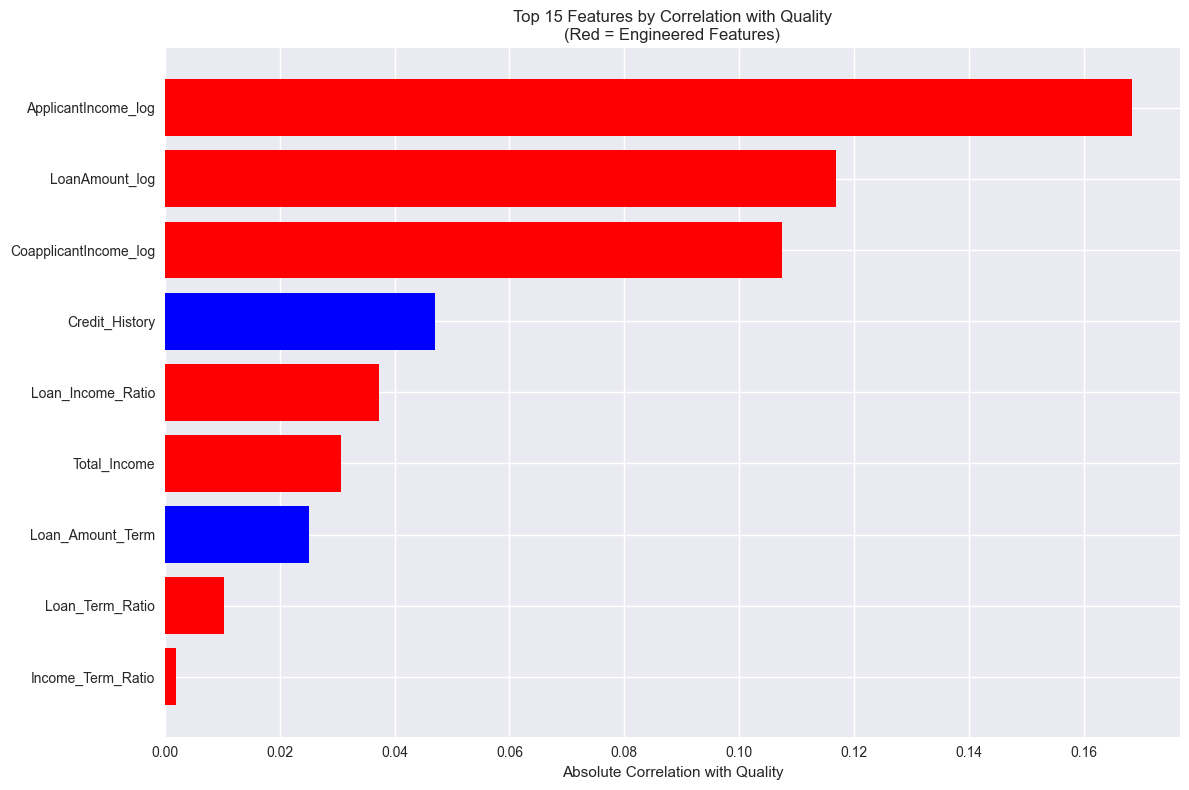


✓ Feature importance analysis completed
✓ 7 engineered features in top 10


In [73]:
# Feature importance analysis to validate EDA-based engineering
print("=== FEATURE IMPORTANCE ANALYSIS ===")

# Calculate correlation with target for all features
feature_correlations = X_train_scaled.corrwith(y_train).abs().sort_values(ascending=False)

# feature_correlations = feature_correlations.copy()
# feature_correlations.rename({
#     'LoanAmount_log': 'LoanAmount',
#     'CoapplicantIncome_log': 'CoapplicantIncome',
#     'ApplicantIncome_log': 'ApplicantIncome'
# }, inplace=True)

print("Top 10 features by correlation with quality:")
for i, (feature, corr) in enumerate(feature_correlations.head(10).items(), 1):
    print(f"{i:2d}. {feature}: {corr:.3f}")

# Check if engineered features are among top features
engineered_features = [col for col in X_train_scaled.columns if any(keyword in col.lower() for keyword in ['ratio', 'interaction', 'balance', 'total', 'log'])]
print(f"\nEngineered features in top 10: {[f for f in engineered_features if f in feature_correlations.head(10).index]}")

# Visualize feature importance
plt.figure(figsize=(12, 8))
top_features = feature_correlations.head(15)
colors = ['red' if any(keyword in f.lower() for keyword in ['ratio', 'interaction', 'balance', 'total', 'log']) else 'blue' for f in top_features.index]

plt.barh(range(len(top_features)), top_features.values, color=colors)
plt.yticks(range(len(top_features)), top_features.index)
plt.xlabel('Absolute Correlation with Quality')
plt.title('Top 15 Features by Correlation with Quality\n(Red = Engineered Features)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print(f"\n✓ Feature importance analysis completed")
print(f"✓ {len([f for f in engineered_features if f in feature_correlations.head(10).index])} engineered features in top 10")


### **Save Preprocessed Data**

Save all preprocessed datasets

In [74]:
print("SAVING PREPROCESSED DATA ")

# Save scaled datasets
X_train_scaled.to_csv('X_train_scaled.csv', index=False)
X_val_scaled.to_csv('X_val_scaled.csv', index=False)
X_test_scaled.to_csv('X_test_scaled.csv', index=False)

# Save target variables
y_train.to_csv('y_train.csv', index=False)
y_val.to_csv('y_val.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

# Save preprocessing objects
import joblib
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(selected_features, 'selected_features.pkl')

# Save feature importance
feature_importance_df = pd.DataFrame({
    'feature': feature_correlations.index,
    'correlation': feature_correlations.values
})
feature_importance_df.to_csv('feature_importance.csv', index=False)

# Save preprocessing summary
preprocessing_summary = {
    'original_shape': df.shape,
    'final_shape': df_processed.shape,
    'selected_features': selected_features,
    'engineered_features': engineered_features,
    'train_samples': X_train_scaled.shape[0],
    'val_samples': X_val_scaled.shape[0],
    'test_samples': X_test_scaled.shape[0],
    'scaling_method': 'RobustScaler',
    'log_transformed': ['ApplicantIncome', 'CoaplicantIncome', 'LoanAmount']
}

import json
with open('preprocessing_summary.json', 'w') as f:
    json.dump(preprocessing_summary, f, indent=2)

print("- Preprocessed data saved successfully!")
print("\nFiles created:")
print("- X_train_scaled.csv, X_val_scaled.csv, X_test_scaled.csv")
print("- y_train.csv, y_val.csv, y_test.csv")
print("- scaler.pkl, selected_features.pkl")
print("- feature_importance.csv, preprocessing_summary.json")


SAVING PREPROCESSED DATA 
- Preprocessed data saved successfully!

Files created:
- X_train_scaled.csv, X_val_scaled.csv, X_test_scaled.csv
- y_train.csv, y_val.csv, y_test.csv
- scaler.pkl, selected_features.pkl
- feature_importance.csv, preprocessing_summary.json
